In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

100.0%


Epoch [1/10], Loss: 1.4942
Epoch [2/10], Loss: 1.1491
Epoch [3/10], Loss: 1.0118
Epoch [4/10], Loss: 0.9325
Epoch [5/10], Loss: 0.8724
Epoch [6/10], Loss: 0.8255
Epoch [7/10], Loss: 0.7830
Epoch [8/10], Loss: 0.7564
Epoch [9/10], Loss: 0.7224
Epoch [10/10], Loss: 0.7025
Accuracy on test set: 72.96%


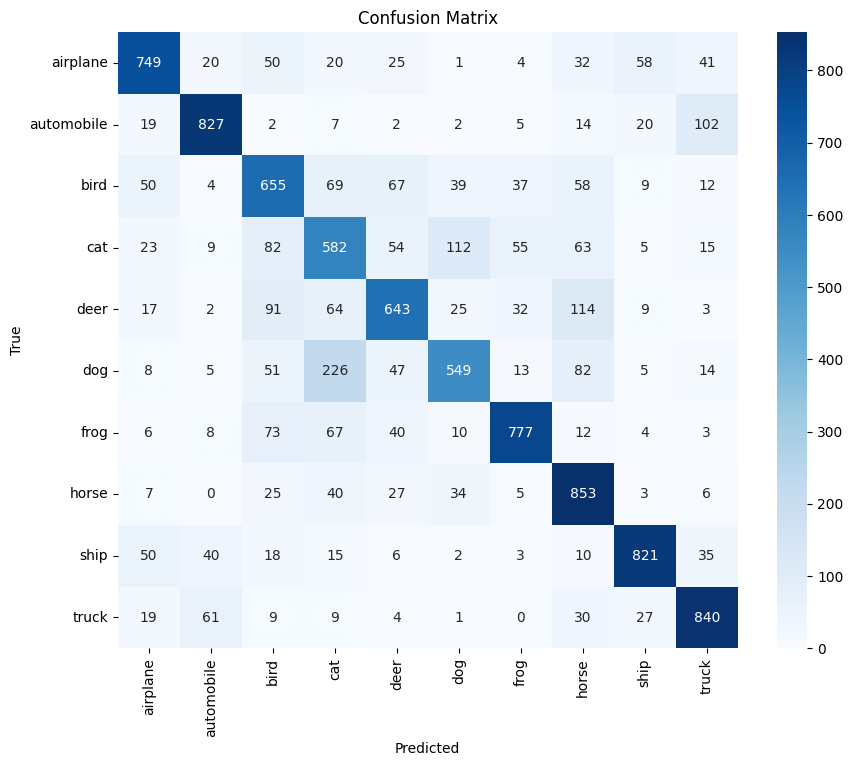

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # 全连接层
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # 卷积 + 激活函数 + 池化
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # 展平
        x = x.view(-1, 64 * 8 * 8)
        # 全连接 + 激活函数
        x = torch.relu(self.fc1(x))
        # 输出层
        x = self.fc2(x)
        return x

# 实例化模型
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 测试模型
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()